In [2]:
import sys, os, platform, inspect

def get_current_file_path():
    # script filename (usually with path)
    filename = inspect.getfile(inspect.currentframe())
    # script directory
    path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    return filename, path


if platform.system() == 'Linux': # Colab setting
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/Colab Notebooks/kaggle'
else:
    _, path = get_current_file_path()    

sys.path.insert(0, path)
os.chdir(path)

sys.path.append(path + '/t-SNE')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

In [0]:
train_data = pd.read_csv('train.csv').to_numpy()

tr_train = torchvision.transforms.Compose([
    Image.fromarray,
    transforms.RandomRotation(20),    
    transforms.RandomResizedCrop(28, scale=(0.7, 1.0)),
    transforms.ToTensor(),
#        transforms.RandomErasing(p=0.2, scale=(0.02, .1)),        
    transforms.Normalize([0.5], [0.5],)
])


tr_valid = torchvision.transforms.Compose([
    Image.fromarray,
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5],)
    ])


X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)
X_train, y_train = torch.tensor(X_train).to(torch.float).reshape(-1, 28, 28),\
                   torch.tensor(y_train)
X_valid, y_valid = torch.tensor(X_valid).to(torch.float).reshape(-1, 28, 28), torch.tensor(y_valid)

X_train = torch.stack([
    tr_train(x.numpy().astype(np.uint8)) for x in torch.unbind(X_train, dim=0)
], dim=0)

X_valid = torch.stack([
        tr_valid(x.numpy().astype(np.uint8)) for x in torch.unbind(X_valid, dim=0)
    ], dim=0)

dset_train = data.TensorDataset(X_train, y_train)
dset_valid = data.TensorDataset(X_valid, y_valid)

# factor = 0.9
# train_len = int(len(dset_train) * factor)
# valid_len = len(dset_train)  - train_len
# dset_train, dset_valid = data.random_split(dset_train, [train_len, valid_len])

batch_size = 16

dloader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_valid = data.DataLoader(dset_valid, batch_size=batch_size, shuffle=True)

tensor([9, 2, 1, 2, 2, 1, 7, 8, 4, 3, 5, 6, 0, 4, 2, 3])


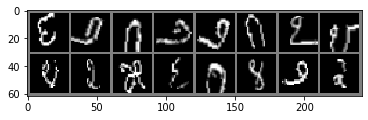

In [5]:
x, y = next(iter(dloader_train))
plt.imshow((torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

tensor([6, 9, 6, 4, 3, 8, 8, 4, 8, 6, 2, 9, 9, 0, 1, 8])


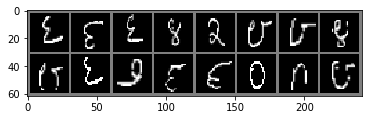

In [6]:
x, y = next(iter(dloader_valid))
plt.imshow((torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

In [0]:
class Save:
    def __init__(self):
        self.ℓ_min = np.inf

    def __call__(self, ℓ, model, verbose=True):
        if ℓ < self.ℓ_min:
            self.ℓ_min = ℓ
            if verbose:
                print(f' ==> saving model')
            torch.save(model.state_dict(), 'model.pt')

def grad_norm(model):
    norm = 0.0
    for param in model.parameters():
        if param.requires_grad:
            norm += torch.norm(param.grad)
    return norm

def train(model, epochs, ℓ_fn, optimizer, dloader_train, dloader_valid, device):
    save_model = Save()
    for i_epoch in range(1, epochs+1):
        norm_val = []
        for x, y in dloader_train:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            ℓ_fn(model(x), y).backward()
            norm_val.append(grad_norm(model).cpu().item())
            optimizer.step()
        model.eval()
        loss_val = []
        loss_acc = []
        
        for x, y in dloader_valid:
            x, y = x.to(device), y.to(device)
            ŷ = model(x)
            ℓ = ℓ_fn(ŷ, y)
            loss_val.append(ℓ.cpu().item())
            loss_acc.append((y == ŷ.argmax(dim=1)).to(torch.float).mean().item())
        model.train()
        print(f'Epoch {i_epoch} loss: {np.array(loss_val).mean():.5f},\
         accuracy: {np.array(loss_acc).mean():.5f},\
          grad norm: {np.array(norm_val).mean():.5f}')
        save_model(np.array(loss_val).mean(), model)

In [0]:
def conv2d_layer(c_in, c_out, k=3, padding=1, bn=True, relu=nn.ReLU()):
    seq = [nn.Conv2d(c_in, c_out, k, padding=padding), relu]
    if bn:
        seq.append(nn.BatchNorm2d(c_out))
    return(nn.Sequential(*seq))

class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16),
            conv2d_layer(16, 32),   nn.MaxPool2d(2),
            conv2d_layer(32, 64),
            conv2d_layer(64, 128),  nn.MaxPool2d(2),
            conv2d_layer(128, 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 128),
            nn.LeakyReLU(), nn.Dropout(),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPool2d(kernel_size=

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16, relu=nn.Identity()),
            conv2d_layer(16, 32, relu=nn.Identity()),   nn.MaxPool2d(2),
            conv2d_layer(32, 64, relu=nn.Identity()),
            conv2d_layer(64, 128, relu=nn.Identity()),  nn.MaxPool2d(2),
            conv2d_layer(128, 256, relu=nn.Identity()))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 128),
            nn.LeakyReLU(), nn.Dropout(),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Identity()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Identity()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Identity()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Identity()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPoo

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(16, 32, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(32, 64, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(64, 128, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(128, 256, relu=nn.LeakyReLU(0.1)))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 128),
            nn.LeakyReLU(0.1), nn.Dropout(),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(128, eps=1e-05

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16, relu=nn.LeakyReLU(0.2)),
            conv2d_layer(16, 32, relu=nn.LeakyReLU(0.2)),
            nn.MaxPool2d(2),
            conv2d_layer(32, 64, relu=nn.LeakyReLU(0.2)),
            conv2d_layer(64, 128, relu=nn.LeakyReLU(0.2)),
            nn.MaxPool2d(2),
            conv2d_layer(128, 256, relu=nn.LeakyReLU(0.2)))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 128),
            nn.LeakyReLU(0.2), nn.Dropout(0.5),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(128, eps=1e-05

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        conv_dim = 64
        leaky = 0.1
        self.feature = nn.Sequential(
            conv2d_layer(1, conv_dim, relu=nn.LeakyReLU(leaky)),
            conv2d_layer(conv_dim, conv_dim*2, relu=nn.LeakyReLU(leaky)),
            nn.MaxPool2d(2),
            conv2d_layer(conv_dim*2, conv_dim*4, relu=nn.LeakyReLU(leaky)),
            conv2d_layer(conv_dim*4, conv_dim*8, relu=nn.LeakyReLU(leaky)),
            nn.MaxPool2d(2),
            conv2d_layer(conv_dim*8, conv_dim*16, relu=nn.LeakyReLU(leaky)))
        
        self.classifier = nn.Sequential(
            nn.Linear(conv_dim * 16 * 7**2, 128),
            nn.LeakyReLU(leaky), nn.Dropout(0.5),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Epoch 1 loss: 0.04252,         accuracy: 0.98850,          grad norm: 16.43047
 ==> saving model
Epoch 2 loss: 0.03058,         accuracy: 0.99200,          grad norm: 8.42683
 ==> saving model
Epoch 3 loss: 0.02900,         accuracy: 0.99167,          grad norm: 6.39855
 ==> saving model
Epoch 4 loss: 0.02861,         accuracy: 0.99133,          grad norm: 4.81041
 ==> saving model
Epoch 5 loss: 0.02636,         accuracy: 0.99217,          grad norm: 3.77040
 ==> saving model
Epoch 6 loss: 0.02527,         accuracy: 0.99233,          grad norm: 2.94696
 ==> saving model
Epoch 7 loss: 0.02550,         accuracy: 0.99267,          grad norm: 2.51221
Epoch 8 loss: 0.02795,         accuracy: 0.99267,          grad norm: 2.14864
Epoch 9 loss: 0.02733,         accuracy: 0.99283,          grad norm: 1.82199
Epoch 10 loss: 0.02639,         accuracy: 0.99267,          grad norm: 1.50181
Epoch 11 loss: 0.02750,         accuracy: 0.99283,          grad norm: 1.33217
Epoch 12 loss: 0.02791,        

In [11]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        conv_dim = 8
        leaky = 0.1
        self.feature = nn.Sequential(
            conv2d_layer(1, conv_dim, relu=nn.LeakyReLU(leaky)),
            conv2d_layer(conv_dim, conv_dim*2, relu=nn.LeakyReLU(leaky)),
            nn.AvgPool2d(2),
            conv2d_layer(conv_dim*2, conv_dim*4, relu=nn.LeakyReLU(leaky)),
            conv2d_layer(conv_dim*4, conv_dim*8, relu=nn.LeakyReLU(leaky)),
            nn.AvgPool2d(2),
            conv2d_layer(conv_dim*8, conv_dim*16, relu=nn.LeakyReLU(leaky)),
            conv2d_layer(conv_dim*16, conv_dim*32, relu=nn.LeakyReLU(leaky)),
            nn.AvgPool2d(2))
        
        self.classifier = nn.Sequential(
            nn.Linear(conv_dim * 32 * 3**2, 128),
            nn.LeakyReLU(leaky), nn.Dropout(0.5),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.00003
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, 400, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

KeyboardInterrupt: ignored

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 16, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(16, 32, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(32, 64, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(64, 128, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(128, 256, relu=nn.LeakyReLU(0.1)))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7**2, 512),
            nn.LeakyReLU(0.1), nn.Dropout(.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1), nn.Dropout(.2),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, 50, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(128, eps=1e-05

In [0]:
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature = nn.Sequential(
            conv2d_layer(1, 64, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(64, 128, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(128, 256, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(256, 512, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2),
            conv2d_layer(512, 1024, relu=nn.LeakyReLU(0.1)),
            conv2d_layer(1024, 2048, relu=nn.LeakyReLU(0.1)),
            nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
            nn.Linear(2048 * 3**2, 128),
            nn.LeakyReLU(0.1), nn.Dropout(),
            nn.Linear(128, 10))
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, 20, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(512, eps

In [0]:
class ResNet(nn.Module):
    def __init__(self, model, in_channels, out_channels):
        super(ResNet, self).__init__()
        self.model = model
        self.bn = nn.BatchNorm2d(out_channels)
        self.ones = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.ones.weight.requires_grad = False
        self.ones.weight.data = torch.ones_like(self.ones.weight)
    
    def forward(self, x):
        return self.model(x) + self.bn(self.ones(x))
        
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()

        self.feature = nn.Sequential(
            ResNet(
                nn.Sequential(
                    conv2d_layer(1, 16, relu=nn.LeakyReLU(0.1)),
                    conv2d_layer(16, 32, relu=nn.LeakyReLU(0.1)),
                ), 1, 32
            ),
            nn.MaxPool2d(2),
            ResNet(
                nn.Sequential(
                    conv2d_layer(32, 64, relu=nn.LeakyReLU(0.1)),
                    conv2d_layer(64, 128, relu=nn.LeakyReLU(0.1)),
                ), 32, 128
            ),
            nn.MaxPool2d(2),
            ResNet(
                nn.Sequential(
                    conv2d_layer(128, 256, relu=nn.LeakyReLU(0.1)),
                    conv2d_layer(256, 512, relu=nn.LeakyReLU(0.1)),
                ), 128, 512
            ),
            nn.MaxPool2d(2))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 3**2, 128),
            nn.LeakyReLU(0.1), nn.Dropout(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, 30, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ones): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0005
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
train(model, 30, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ones): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [0]:
class ResNet(nn.Module):
    def __init__(self, model, in_channels, out_channels):
        super(ResNet, self).__init__()
        self.model = model
        self.bn = nn.BatchNorm2d(out_channels)
        self.ones = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.ones.weight.requires_grad = False
        self.ones.weight.data = torch.ones_like(self.ones.weight)
    
    def forward(self, x):
        return self.model(x) + self.bn(self.ones(x))
        
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()

        self.feature = nn.Sequential(
            nn.Sequential(
                conv2d_layer(1, 16),
                conv2d_layer(16, 32, relu=nn.Identity()),
            ),
            nn.MaxPool2d(2),

            nn.Sequential(
                conv2d_layer(32, 32),
                conv2d_layer(32, 32, relu=nn.Identity()),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(32, 64),
                    conv2d_layer(64, 64, relu=nn.Identity()),
                ), 32, 64
            ),

            nn.Sequential(
                conv2d_layer(64, 64),
                conv2d_layer(64, 64, relu=nn.Identity()),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(64, 128),
                    conv2d_layer(128, 128, relu=nn.Identity()),
                ), 64, 128
            ),
            nn.MaxPool2d(2),

            nn.Sequential(
                conv2d_layer(128, 128),
                conv2d_layer(128, 128, relu=nn.Identity()),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(128, 256),
                    conv2d_layer(256, 256, relu=nn.Identity()),
                ), 128, 256
            ),

            nn.Sequential(
                conv2d_layer(256, 256),
                conv2d_layer(256, 256, relu=nn.Identity()),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(256, 512),
                    conv2d_layer(512, 512, relu=nn.Identity()),
                ), 256, 512
            ),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 3**2, 128),
            nn.LeakyReLU(0.1), nn.Dropout(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 30, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Identity()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Identity()
        (2): BatchNorm2d(32, eps=1e-05

In [0]:
class ResNet(nn.Module):
    def __init__(self, model, in_channels, out_channels):
        super(ResNet, self).__init__()
        self.model = model
        self.bn = nn.BatchNorm2d(out_channels)
        self.ones = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.ones.weight.requires_grad = False
        self.ones.weight.data = torch.ones_like(self.ones.weight)
    
    def forward(self, x):
        return self.model(x) + self.bn(self.ones(x))
        
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()

        self.feature = nn.Sequential(
            nn.Sequential(
                conv2d_layer(1, 16),
                conv2d_layer(16, 32),
            ),
            nn.MaxPool2d(2),

            nn.Sequential(
                conv2d_layer(32, 32),
                conv2d_layer(32, 32),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(32, 64),
                    conv2d_layer(64, 64),
                ), 32, 64
            ),

            nn.Sequential(
                conv2d_layer(64, 64),
                conv2d_layer(64, 64),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(64, 128),
                    conv2d_layer(128, 128),
                ), 64, 128
            ),
            nn.MaxPool2d(2),

            nn.Sequential(
                conv2d_layer(128, 128),
                conv2d_layer(128, 128),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(128, 256),
                    conv2d_layer(256, 256),
                ), 128, 256
            ),

            nn.Sequential(
                conv2d_layer(256, 256),
                conv2d_layer(256, 256),
            ),
            ResNet(
                nn.Sequential(
                    conv2d_layer(256, 512),
                    conv2d_layer(512, 512),
                ), 256, 512
            ),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 3**2, 128),
            nn.LeakyReLU(0.1), nn.Dropout(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.00002
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 30, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, moment

In [0]:
def conv2d_layer(c_in, c_out, k=3, padding=1, stride=2, bn=True):
    seq = [nn.Conv2d(c_in, c_out, k, padding=padding, stride=stride)]
    if bn:
        seq.append(nn.BatchNorm2d(c_out))
    return(nn.Sequential(*seq))

class ResNet(nn.Module):
    def __init__(self, model, in_channels, out_channels, stride=2, padding=0):
        super(ResNet, self).__init__()
        self.model = model
        self.bn = nn.BatchNorm2d(out_channels)
        self.ones = nn.Conv2d(in_channels, out_channels, 1, stride=stride, padding=padding, bias=False)
        self.ones.weight.requires_grad = False
        self.ones.weight.data = torch.ones_like(self.ones.weight)
    
    def forward(self, x):
        return self.model(x) + self.bn(self.ones(x))
        
class Model(nn.Module):
    '''Docs here ...'''
    def __init__(self):
        super(Model, self).__init__()

        self.feature = nn.Sequential(
                            ResNet( 
                                nn.Sequential(
                                    conv2d_layer(1 , 64, k=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    conv2d_layer(64, 64, k=3, padding=1, stride=1)),
                                1, 64),
                            ResNet( 
                                nn.Sequential(
                                    conv2d_layer(64, 128, k=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    conv2d_layer(128, 128, k=3, padding=1, stride=1)),
                                64, 128),
                            ResNet( 
                                nn.Sequential(
                                    conv2d_layer(128, 256, k=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    conv2d_layer(256, 256, k=3, padding=1, stride=1)),
                                128, 256),
                            ResNet( 
                                nn.Sequential(
                                    conv2d_layer(256, 512, k=3, padding=1, stride=2),
                                    nn.ReLU(),
                                    conv2d_layer(512, 512, k=3, padding=1, stride=1)),
                                256, 512),
                        )


        self.classifier = nn.Sequential(
            nn.Linear(512 * 2**2, 64),
            nn.ReLU(0.1), nn.Dropout(.25),
            nn.Linear(64, 10))

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ℓ_fn = nn.CrossEntropyLoss()
model = Model().to(device)
print(model)
lr = 0.00002
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, 50, ℓ_fn, optimizer, dloader_train, dloader_valid, device)

Model(
  (feature): Sequential(
    (0): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ones): Conv2d(1, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
    (1): ResNet(
      (model): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(


KeyboardInterrupt: ignored